# 0. Exercise on plate notation

Plate notation can also be used to represented repeated substructure with shared parameters (conditional probability distributions). 

<img src="skills.png" alt="Drawing">

Assume that we have two students and two course. What does the unfolded models for the two plate models above look like?

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Setup
We will now continue with more Pyro relateed exercises. Let's begin by installing and importing the modules we'll need.

In [1]:
#!pip install -q --upgrade pyro-ppl torch
import pyro
import torch
import pyro.distributions as dist


### **<span style="color:red">Exercise introduction</span>**

The main goal with the exercises below is to get some experience with probabilistic modeling. Here we exemplify modeling using Pyro, but any other probabilistic programming language could also have been used.

There are two explicit exercises embedded in this notebook (marked with red as above). Before working on these exercises, step carefully through the notebook leading up to the exercises and make sure that you have a good understanding on what is done in the individual steps.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# 1. **Pyro’s distributions**:


Pyro provides a wide range of distributions: **Normal, Beta, Cauchy, Dirichlet, Gumbel, Poisson, Pareto, etc.**

In [3]:
normal = dist.Normal(0,1)
normal


Normal(loc: 0.0, scale: 1.0)


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Samples from the distributions are [Pytorch’s Tensor objects](https://pytorch.org/cppdocs/notes/tensor_creation.html) (i.e. multidimensional arrays).

In [4]:
sample = normal.sample()
sample


tensor(0.7152)

In [5]:
sample = normal.sample(sample_shape=[3,4])
sample


tensor([[ 0.0624,  0.7540,  0.5288,  0.9356],
        [ 0.8189, -0.3786,  0.3758, -1.2115],
        [ 0.6507, -1.8753, -0.5512,  0.6264]])

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

We can query the **dimensionlity** of a tensor with the ``shape`` property


In [6]:
sample = normal.sample(sample_shape=[3,4,5])
sample.shape


torch.Size([3, 4, 5])


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Operations, like **log-likelihood**, are defined over tensors.

In [7]:
normal.log_prob(sample)


tensor([[[-1.4113, -2.1572, -1.8318, -0.9234, -2.1741],
         [-1.1982, -0.9574, -0.9224, -1.0750, -1.1258],
         [-2.4877, -1.0441, -1.1572, -0.9208, -0.9903],
         [-1.0297, -2.1980, -3.1200, -1.2850, -0.9296]],

        [[-1.0012, -2.6566, -1.1358, -2.3502, -1.2554],
         [-1.0524, -1.6577, -0.9195, -2.0844, -1.1291],
         [-0.9243, -0.9487, -0.9192, -1.2126, -2.0076],
         [-0.9884, -0.9198, -0.9191, -0.9283, -1.5514]],

        [[-1.1017, -1.1214, -1.2197, -1.8593, -0.9625],
         [-1.3959, -1.2039, -1.0212, -0.9748, -2.3501],
         [-1.4620, -2.3951, -4.4266, -1.2656, -1.2034],
         [-1.0444, -0.9828, -1.2428, -0.9239, -1.3120]]])

In [8]:
torch.sum(normal.log_prob(sample))


tensor(-84.9699)

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Multiple distributions can be embedded in single object. Below we define three Normal distributions with different means but the same scale in a single object.

In [9]:
normal = dist.Normal(torch.tensor([1.,2.,3.]),1.)
normal


Normal(loc: torch.Size([3]), scale: torch.Size([3]))

In [10]:
normal.sample()


tensor([2.0407, 1.8604, 2.9886])

In [11]:
normal.log_prob(normal.sample())


tensor([-1.4895, -0.9197, -1.3804])

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

### **<span style="color:red">Exercise: Open the notebook and play around</span>**

* Test that everything works.
* Play a bit with the code in Section 1 of the notebook.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# 2. **Pyro’s models**:

---
* In Pyro, a probabilistic model is defined as a **stochastic function** (i.e. every time it is run, it returns a new sample).

* Each random variable is associated with a **primitive stochastic function** using the construct ``pyro.sample(...)``.
---


### 2.1 A Temperature Model



As initial running example, we consider the problem of **modelling the temperature**. We first start with a simple model where temperture is modeled using a random Normal variable.

In [12]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    return temp

print(model())
print(model())


tensor(13.7558)
tensor(14.4367)


See how the model is a stochastic function which **returns a different value everytime it is invoked**. 

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### 2.2 A Temperature-Sensor Model

In Pyro, a stochastic method is defined as a composition of primitive stochastic functions.

*The temperature Model:* 

We consider the relation between the temperature and a sensor. 
  * The temperature sensor gives **noisy observations** about the real temperature.
  * The **error** of the sensor's measurements **is known**.
  * A graphical representation of this model:

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/PGM-Tem-Sensor.png?raw=1" alt="Drawing" width="150">
</center>


In [13]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0))
    return (temp, sensor)

out1 = model()
out1


(tensor(17.0439), tensor(18.2041))

The above method defines a joint probability distribution:
$$p(sensor, temp) = p(sensor|temp)p(temp)$$


In this case, we have a simple dependency between the variables. But, as we are in a PPL, dependencies can be expressed in terms of complex deterministic functions (more examples later).
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


In [14]:
#Visualize the model
pyro.render_model(model)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

# 3. **Pyro’s inference** :

### Auxiliary inference functions

To make inference on Pyro, we will use a variational inference method, which performs gradient-based optimization to solve the inference problem. More details on variational inference will follow in the next lecture. 

In [15]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal


def svi(temperature_model, obs, guide=None, num_steps = 5000, plot = False, verbose=True):
    pyro.clear_param_store()

    if guide is None:
        guide = AutoDiagonalNormal(model)

    svi = pyro.infer.SVI(model=temperature_model,
                         guide=guide,
                         optim=SGD({"lr": 0.001, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []

    for t in range(num_steps):
        losses.append(svi.step(obs))
        if t%250==0:
            print('Step: '+str(t)+'. Loss: ' +str(losses[-1]))


    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()

    if verbose:
        print("Inference results:")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name))


A few notes on guides:
* To make inference in Pyro over a given model we need to define a *guide*, this *guide* has the same signature as its counterpart model. 

* The guide must provide samples for those variables of the model which are not observed. Again the ``pyro.sample`` construct. 

* Guides are also parametrized using Pyro's parameters (``pyro.param``), so the variational inference algorithm will optimize these parameters. 

* All of this will be explained in detail during the next lecture.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

### 3.1  Conditioning on a single observation

Now, we continue with the last model defined in section 2.2, and assume we have a sensor reading and we want to compute the posterior distribution over the real temperature. 
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/PGM-Tem-Sensor.png?raw=1" alt="Drawing" width="150">
</center>

This can be achived by introducing **observations in the random variable** with the keyword ``obs=``.

In [16]:
#The observatons
obs = {'sensor': torch.tensor(18.0)}

def model(obs):
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])


In [17]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Inference is made using the previously defined auxiliary functions, ``svi`` and ``guide``. 

We can query the **posterior probability distribution**: 


$$p(temp | sensor=18)=\frac{p(sensor=18|temp)p(temp)}{\int p(sensor=18|temp)p(temp) dtemp}$$

Step: 0. Loss: 11.853480458259583
Step: 250. Loss: 7.649094820022583
Step: 500. Loss: 6.100058197975159
Step: 750. Loss: 4.970267653465271
Step: 1000. Loss: 4.405615568161011
Step: 1250. Loss: 3.9689571857452393
Step: 1500. Loss: 3.2631601691246033
Step: 1750. Loss: 3.111061692237854
Step: 2000. Loss: 3.282896101474762
Step: 2250. Loss: 3.063496708869934
Step: 2500. Loss: 2.786586582660675
Step: 2750. Loss: 2.8090290427207947
Step: 3000. Loss: 2.8886751532554626
Step: 3250. Loss: 2.085628867149353
Step: 3500. Loss: 2.778656005859375
Step: 3750. Loss: 2.552612781524658
Step: 4000. Loss: 2.6947314143180847
Step: 4250. Loss: 2.5905743837356567
Step: 4500. Loss: 2.6811654567718506
Step: 4750. Loss: 2.600482702255249


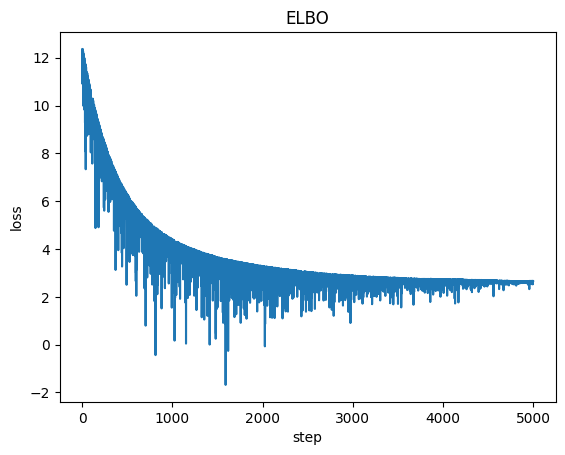

Inference results:
AutoDiagonalNormal.loc Parameter containing:
tensor([17.3720], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.8629], grad_fn=<SoftplusBackward0>)
P(Temperature|Sensor=18.0) = 
Normal(loc: 17.37198829650879, scale: 0.8629287481307983)



In [18]:
#Run inference
svi(model,obs, plot=True)

#Print results
print("P(Temperature|Sensor=18.0) = ")
print(dist.Normal(pyro.param("AutoDiagonalNormal.loc").item(), pyro.param("AutoDiagonalNormal.scale").item()))
print("")


### 3.2  Learning from a bunch of observations

Let us assume we have a **set of observations** about the temperature at different time steps. 

* Following a probabilistic modelling approach, we define a **set of random variables**.

* One random variable for each **observation**, using a standard ``for-loop``.


In [19]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(15.0, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])


In [ ]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

Step: 0. Loss: 145.256729722023
Step: 250. Loss: 104.49658918380737
Step: 500. Loss: 77.79321253299713
Step: 750. Loss: 66.97565197944641
Step: 1000. Loss: 56.23918628692627
Step: 1250. Loss: 52.83460330963135
Step: 1500. Loss: 48.85405904054642
Step: 1750. Loss: 46.37905478477478


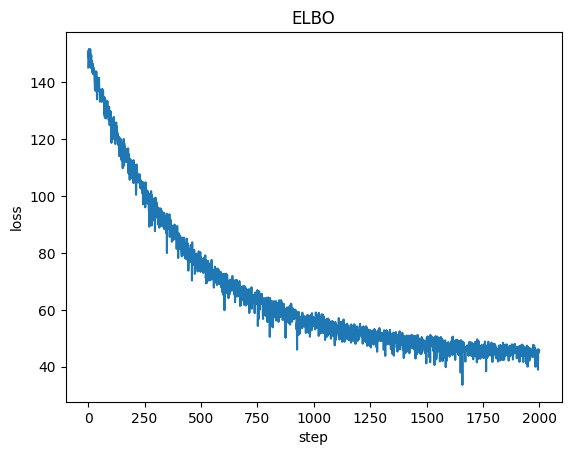

Inference results:
AutoDiagonalNormal.loc Parameter containing:
tensor([17.2389, 17.7848, 18.2291, 17.2079, 18.9784, 20.5486, 18.9712, 19.6340,
        18.3716, 18.8743], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.4850, 0.4812, 0.4833, 0.4825, 0.4714, 0.4774, 0.4832, 0.4705, 0.4794,
        0.4812], grad_fn=<SoftplusBackward0>)


In [20]:
#Run inference
svi(model,obs, num_steps=2000, plot=True)



<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png" alt="Drawing" width=2000 height=20>

---
What if we do **not know the mean temperature** (as illustrated in the graphical model below)?
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/PGM-Tem_sensor4.png?raw=1" alt="Drawing" width="150">
</center>

* We can **infer the parameter from the data** by, e.g., using a **maximum likelihood** approach,
$$ \mu_{t} = \arg\max_\mu \ln p(s_1,\ldots,s_n|\mu) = \arg\max_\mu \prod_i \int_{t_i} p(s_i|t_i)p(t_i|\mu) dt_i, $$ where $s_i$ and $t_i$ denote the sensor reading and the real temperature at time $i$. 

For now we do not consider the **underlying inference problem** We just define the model and let the **PPL's engine** do the work for us. 
* We use Pyro's parameters (defined as ``pyro.param``), which are free variables we can optimize. 


In [21]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.param('mean_temp', torch.tensor(15.0))
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])


In [ ]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [22]:
#Run inference
svi(model, obs, num_steps=2500, verbose=True)

#Print results
print("Estimated Mean Temperature (MLE):")
mle_mean_temp = pyro.param("mean_temp").item()
print(mle_mean_temp)


Step: 0. Loss: 161.34423565864563


Step: 250. Loss: 106.48215043544769
Step: 500. Loss: 78.29717206954956
Step: 750. Loss: 56.18175935745239
Step: 1000. Loss: 41.03458380699158
Step: 1250. Loss: 35.10193848609924
Step: 1500. Loss: 32.160018265247345
Step: 1750. Loss: 26.106971263885498
Step: 2000. Loss: 16.708813667297363
Step: 2250. Loss: 22.26562011241913
Inference results:
mean_temp tensor(19.1224, requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([17.9942, 18.5379, 18.9744, 17.7470, 19.7853, 21.4044, 19.7504, 20.4771,
        19.0931, 19.6511], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.5938, 0.5852, 0.5910, 0.5860, 0.5944, 0.5991, 0.5920, 0.5884, 0.5892,
        0.5961], grad_fn=<SoftplusBackward0>)
Estimated Mean Temperature (MLE):
19.12237548828125


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png" alt="Drawing" width=2000 height=20>

Instead of performing *maximum likelihood* learning, we can perform **Bayesian learning**.
* We treat the unknown quantity as a **random variable**.

* This model can be graphically represented as follows:

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/PGM-Tem-Sensor2.png?raw=1" alt="Drawing" width="150">
</center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

In [23]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])


In [ ]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

We perform inference over this model (see Slides from Lecture 8):

 $$ p(\mu_t | s_1,\ldots, s_n)=\frac{p(\mu_t)\prod_{i=1}^n \int p(s_i|t_i)p(t_i|\mu_t)dt_i }{\int \prod_{i=1}^n p(s_i|\mu_t)p(\mu_t) d\mu} $$


Here we will use an explicitly defined guide, simply to be able to pick out the relevant parameters by name.

In [24]:
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))


In [25]:
import time

#Run inference
start = time.time()
svi(model, obs, guide, num_steps=1000, verbose=False)

#Print results
print("P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
end = time.time()
print(f"{(end - start)} seconds")


Step: 0. Loss: 25.14797079563141


Step: 250. Loss: 22.007104456424713
Step: 500. Loss: 23.39054363965988
Step: 750. Loss: 23.675662100315094
P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =
Normal(loc: 19.291488647460938, scale: 0.616420328617096)

18.936118602752686 seconds


As we also saw in the last lecture, the result of the learning is **not a point estimate**. Instead we have a **posterior distribution**, which captures the **uncertainty** about the estimation.

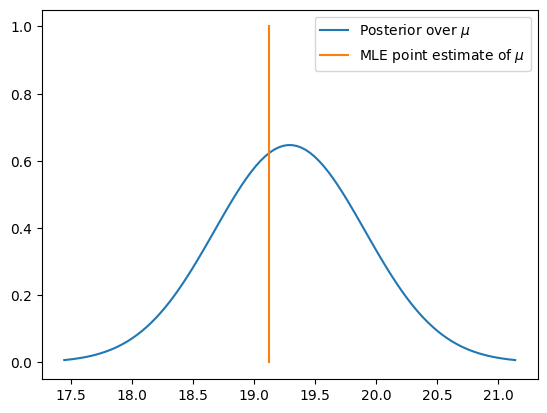

In [26]:
import numpy as np
import scipy.stats as stats

mu = pyro.param("mean").item()
scale = pyro.param("scale").item()
x = np.linspace(mu - 3*scale, mu + 3*scale, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior over $\mu$')
point = mle_mean_temp # Previously calculated above
plt.plot([point, point],[0., 1.], label='MLE point estimate of $\mu$')
plt.legend()
plt.show()


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png" alt="Drawing" width=2000 height=20>


### 3.3 The use of ``plate`` construct

* Pyro can exploit **conditional independencies and vectorization** to make inference much faster. 

* This can be done with the construct **``plate``**. 

* With this construct, we can indicate that the variables $s_i$ and $t_i$ are **conditionally indepdendent** from other variables $s_j$ and $t_j$ given $\mu_t$. 

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/PGM-Tem-Sensor2.png?raw=1" alt="Drawing" width="150">
</center>

In [ ]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])


The ``plate`` construct reflects the standard notational use in graphical models denoting the **repetition of some parts of of the graph**. 
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/PGM-Tem-Sensor3.png?raw=1" alt="Drawing" width="250">
</center>

We can here make a distinction between **local** and **global** random variables: 

* **Local random variables** caputure **specific information** about the $i$-th data sample (i.e. the real temperature at this moment in time).

* **Global random variables** capture **common information** about all the data samples (i.e. the average temperature of all data samples). 

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Observe how inference in this model is much **faster**. 

In [ ]:
#Define the guide
def guide(obs_sensor):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        pyro.sample('temp', dist.Normal(mean_i, scale_i))


In [ ]:
#Run inference
start = time.time()
svi(model, obs, guide, num_steps=1000)

#Print results
print("P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
end = time.time()
print(f"{(end - start)} seconds")


Step: 0. Loss: 21.68138861656189
Step: 250. Loss: 22.68173599243164
Step: 500. Loss: 21.899161159992218
Step: 750. Loss: 22.048187613487244
Inference results:
mean tensor(19.3019, requires_grad=True)
scale tensor(0.6109, grad_fn=<AddBackward0>)
mean_tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) tensor([18.1961, 18.8237, 19.2327, 18.0451, 20.1602, 21.9077, 20.1312, 20.9352,
        19.4882, 19.9553], requires_grad=True)
scale_tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) tensor(0.8703, grad_fn=<AddBackward0>)
P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =
Normal(loc: 19.30185890197754, scale: 0.6109355688095093)

5.57600998878479 seconds


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### **<span style="color:red">Exercise 2: </span>The role of *prior distributions* in learning**

In this case we just want to illustrate how the output of learning depends of the particular prior we introduce in the model. Play with different options and extract conclusions:

1. What happens if we change the mean of the prior?
2. What happens if we change the scale of the prior?
3. What happens to the posterior if the number of data samples deacreases and increases?

The code below might be helpful.

Step: 0. Loss: 22.525341243645677


Step: 250. Loss: 19.5123391023127
Step: 500. Loss: 20.773969412806572
Step: 750. Loss: 22.533085243713632
P(Temperature|Sensor=[16.8  18.84 17.24 16.91 15.53 17.12 17.35 20.93 17.02 17.81]) = 
Normal(loc: 17.565044403076172, scale: 0.6322935223579407)


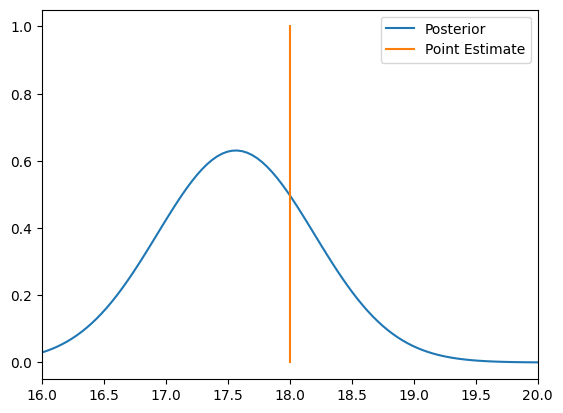

In [ ]:
#The observatons
sample_size = 10
obs = {'sensor': torch.tensor(np.random.normal(18,2,sample_size))}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(18.0, 2.0))
    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])

#Run inference
svi(model, obs, guide, num_steps=1000, verbose=False)

#Print results
print(f"P(Temperature|Sensor={np.array2string(obs['sensor'].numpy(), precision=2)}) = ")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))

x = np.linspace(16, 20, 100)
plt.plot(x, stats.norm.pdf(x, pyro.param("mean").item(), pyro.param("scale").item()), label='Posterior')
point = 18
plt.plot([point, point],[0., 1.], label='Point Estimate')
plt.xlim(16,20)
plt.legend()
plt.show()


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Icecream Shop

In this self study session, you will be modeling the sales in an ice cream shop. Below you will find an initial specification, and in the following sections you should elaborate on this initial specificaton.

The basis for our model is that 
* We **record the ice-cream sales and the average temperature of the day** (using a temperature sensor).

* We know **temperature affects the sales** of ice-creams.

* We want to **precisely model** how temperature affects ice-cream sales.

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/Ice-cream_shop_-_Florida.jpg" alt="Drawing" width=300 >
</center>

Note that the model given below is a extension of the temperature model that we explored during the last lecture.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


## Model specification

* We have **observations** from temperature and sales:
>- The relation between the daily temperature $t_i$ and the measured temperature $s_{t,i}$ will be modeled with a Normal distribution as in the last lecture. 
* Daily sales $s_i$ are modeled with a <a href="https://en.wikipedia.org/wiki/Poisson_distribution">Poisson distribution</a>, which expresses the probability of a given number of sales per day based on a so-called rate parameter (the mean and variance of the Poisson distribution is also equal to the rate parameeter):
>- We assume that the rate of the Poisson distribution **linearly depends of the real temperature**.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model.png?raw=1" alt="Drawing" width=700>
</center>



### Data

In [27]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}


### Pyro specification of the ice-cream model

In [28]:
def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])


In [ ]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


## Auxiliary functions needed for inference and learning
Like before we also need an some auxiliary functions to take care of inference. We haven't disucsssed the details of these yet, so just skim this part for now.

In [29]:
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))


In [30]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal


def svi(temperature_model, obs, guide=None, num_steps = 5000, plot = False, verbose=True):
    pyro.clear_param_store()

    if guide is None:
        guide = AutoDiagonalNormal(model)

    svi = pyro.infer.SVI(model=temperature_model,
                         guide=guide,
                         optim=SGD({"lr": 0.001, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []

    for t in range(num_steps):
        losses.append(svi.step(obs))
        if t%250==0:
            print('Step: '+str(t)+'. Loss: ' +str(losses[-1]))


    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()

    if verbose:
        print("Inference results:")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name))


## Learning and inference

Let's take our model out for a test run

In [31]:
#Run inference
svi(model, obs, guide, num_steps=1000, verbose=False)

#Print results
print("Posterior temperature mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))


Step: 0. Loss: 4915.827966451645


Step: 250. Loss: 63.85545456409454
Step: 500. Loss: 62.78349566459656
Step: 750. Loss: 64.09137654304504
Posterior temperature mean
Normal(loc: 19.2745418548584, scale: 0.626004159450531)

Posterior alpha
Normal(loc: 19.773910522460938, scale: 1.797942876815796)

Posterior beta
Normal(loc: 1.5260900259017944, scale: 0.12132102251052856)


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 1: Analyze the model above </span> 
* Consider the model specification together with the posterior distributions over the model parameters. Do the these distributions appear reasonabale to you considering the model and the data that you have supplied?

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 2: Introduce Humidity in the Icecream shop model </span> 

In this exercise you should extend the model above to also account for the daily humidity $h_i$:
* Assume we also have a bunch of daily humidity sensor measurements $s_{h,i}$.
* Assume the **sales are also linearly influenced by the humidity**.

Extend the model above in order to integrate these new pieces of information.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model-Humidity.png?raw=1" alt="Drawing" width=1000>
</center>




In [36]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])

        humidity = pyro.sample('humidity', dist.Normal(mean_humidity, 2.0))
        sensor_humidity = pyro.sample('sensor_humidity', dist.Normal(humidity, 1.0), obs=obs['sensor_humidity'])

        #Add the linear dependency for the rate with respect to temp and humidity
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp + gamma*humidity)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])


In [ ]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))

    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        humidity = pyro.sample('humidity', dist.Normal(mean_humidity, 2.0))
        sensor_humidity = pyro.sample('sensor_humidity', dist.Normal(humidity, 1.0), obs=obs['sensor_humidity'])

        rate = torch.max(torch.tensor(0.001), alpha + beta*temp + gamma*humidity)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])


In [ ]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again we need a guide for performing inference (you need not worry about the details of this part)

In [37]:
#@title
#Auxiliary Guide Code
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(obs['sensor_humidity']))
    scaleH = pyro.param("scaleH", torch.tensor(1.), constraint=constraints.positive)
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(meanH, scaleH))


    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']), constraint=constraints.positive)
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0), constraint=constraints.positive)
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(1.0), constraint=constraints.positive)
    gamma_scale = pyro.param("gamma_scale", torch.tensor(1.), constraint=constraints.positive)
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param('meanH_i', obs['sensor_humidity'][i])
        scaleH_i = pyro.param('scaleH_i', torch.tensor(1.), constraint=constraints.positive)
        humidity = pyro.sample('humidity', dist.Normal(meanH_i, scaleH_i))


In [38]:
#Run inference
svi(model, obs, guide, num_steps=1000)

#Print results
print("Posterior Temperature Mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior Humidity Mean")
print(dist.Normal(pyro.param("meanH").item(), pyro.param("scaleH").item()))
print("")
print("Posterior Alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior Beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))
print("")
print("Posterior Gamma")
print(dist.Normal(pyro.param("gamma_mean").item(), pyro.param("gamma_scale").item()))


Step: 0. Loss: 477.47234082221985
Step: 250. Loss: 180.4883142709732
Step: 500. Loss: 178.3832436800003
Step: 750. Loss: 174.81701451539993
Inference results:
mean tensor(19.3279, requires_grad=True)
scale tensor(0.6143, grad_fn=<AddBackward0>)
meanH tensor(86.2191, requires_grad=True)
scaleH tensor(0.6588, grad_fn=<AddBackward0>)
alpha_mean tensor(21.4685, grad_fn=<AddBackward0>)
alpha_scale tensor(1.8629, grad_fn=<AddBackward0>)
beta_mean tensor(1.2939, grad_fn=<AddBackward0>)
beta_scale tensor(0.1202, grad_fn=<AddBackward0>)
gamma_mean tensor(2.2326e-15, grad_fn=<AddBackward0>)
gamma_scale tensor(0.0154, grad_fn=<AddBackward0>)
mean_i tensor([18.1708, 18.8071, 19.1952, 17.9758, 20.1391, 21.9301, 20.2099, 20.9364,
        19.4804, 20.0640], requires_grad=True)
scale_i tensor(0.8704, grad_fn=<AddBackward0>)
meanH_i tensor([83.3101, 87.4099, 71.6883, 76.0084, 81.1646, 93.0111, 90.4421, 91.3396,
        97.1646, 92.1273], requires_grad=True)
scaleH_i tensor(0.9407, grad_fn=<AddBackward0

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# 5.  **Temporal Models**

If we expect that there might a temporal dependency between the variables, we can capture this in the model specification.

Let us assume that there is a **temporal dependency** between the variables.

* E.g. the current real temperature must be similar to the real temperature in the previous time step.

This temporal dependency can be modeled using a **for-loop** in Pyro as illustrated in the graphical representation.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/tempmodel-temporal-III.png" alt="Drawing" style="width: 350px;" >


Observe how this temporal model shares commonalities with the temporal models that we discussed a couple of lectures a go. 

In [39]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        prev_temp = temp


In [ ]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again we need a guide for performing inference (you need not worry about the details of this part)

In [40]:
#@title
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))


In [41]:
import time

#Run inference
svi(model, obs, guide=guide, num_steps=1000)

smooth_temp=[]
for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'mean_{i}').item())

print('Finished')


Step: 0. Loss: 28.874792456626892
Step: 250. Loss: 21.856022715568542
Step: 500. Loss: 25.516498506069183
Step: 750. Loss: 22.06435662508011
Inference results:
mean tensor(18.4103, requires_grad=True)
scale tensor(1.3384, grad_fn=<AddBackward0>)
mean_0 tensor(18.3780, requires_grad=True)
scale_0 tensor(0.8160, grad_fn=<AddBackward0>)
mean_1 tensor(18.7140, requires_grad=True)
scale_1 tensor(0.8225, grad_fn=<AddBackward0>)
mean_2 tensor(18.8776, requires_grad=True)
scale_2 tensor(0.8379, grad_fn=<AddBackward0>)
mean_3 tensor(18.5446, requires_grad=True)
scale_3 tensor(0.8325, grad_fn=<AddBackward0>)
mean_4 tensor(20.2728, requires_grad=True)
scale_4 tensor(0.8357, grad_fn=<AddBackward0>)
mean_5 tensor(21.5338, requires_grad=True)
scale_5 tensor(0.8497, grad_fn=<AddBackward0>)
mean_6 tensor(20.8012, requires_grad=True)
scale_6 tensor(0.8251, grad_fn=<AddBackward0>)
mean_7 tensor(20.7527, requires_grad=True)
scale_7 tensor(0.8361, grad_fn=<AddBackward0>)
mean_8 tensor(19.9244, requires_gr

We can now plot the **observered measurements** of the temperature **against** the inferred **real temperature**.

* By querying the **local hidden** we can **smooth** the temperature.

* The **recovered temperature** is much less noisy than the measured one. 

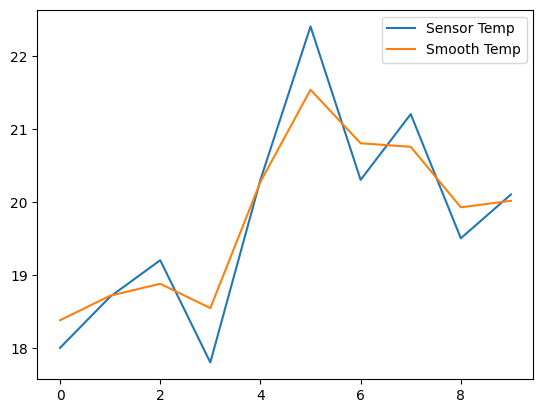

In [42]:
import matplotlib.pyplot as plt
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

### <span style="color:red">Exercise 3:  Temporal Extension of the Iceacream shop model </span> 

Assume that:
* temperature depends of the **temperature in the previous day**.
* humidity depends of the **humidity in the previous day**.
* sales depends on the **current temperature and humidity**.

Use the following **graphical representation for reference**.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/icecream-model-temporal.png" alt="Drawing" width=800 >

Note that the plate representation has to be coded in Pyro using a **``for-loop``**.

In [54]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}
#with pyro.plate('a', obs['sensor'].shape[0]):


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))

    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))

    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
            humidity = pyro.sample(f'humidity_{i}', dist.Normal(mean_humidity, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
            humidity = pyro.sample(f'humidity_{i}', dist.Normal(prev_humidity, 2.0))

        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        sensor_humidity = pyro.sample(f'sensor_humidity_{i}', dist.Normal(humidity, 1.0), obs=obs['sensor_humidity'][i])

        rate = torch.max(torch.tensor(0.001), alpha + beta*temp + gamma*humidity)
        sales = pyro.sample(f'sales_{i}', dist.Poisson(rate), obs=obs['sales'][i])

        prev_temp = temp
        #Keep humidity for the next time step.
        prev_humidity = humidity


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Again we need a guide for performing inference (you need not worry about the details of this part)

In [55]:
#@title
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(obs['sensor_humidity']), constraint=constraints.positive)
    scaleH = pyro.param("scaleH", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    humidity_mean = pyro.sample('mean_humidity', dist.Normal(meanH, scaleH))


    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(0.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(0.0))
    gamma_scale = pyro.param("gamma_scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.greater_than(0.01))
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param(f'meanH_{i}', obs['sensor_humidity'][i])
        scaleH_i = pyro.param(f'scaleH_{i}', torch.tensor(1.), constraint=constraints.greater_than(0.01))
        humidity_i = pyro.sample(f'humidity_{i}', dist.Normal(meanH_i, scaleH_i))


In [56]:
import time

#Run inference
svi(model, obs, guide, num_steps=2000)

smooth_temp=[]
smooth_humidity=[]

for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'mean_{i}').item())
    smooth_humidity.append(pyro.param(f'meanH_{i}').item())

print('Finished')


Step: 0. Loss: 5044.000468492508


Step: 250. Loss: 159.29073452949524
Step: 500. Loss: 129.21805477142334
Step: 750. Loss: 131.60716998577118
Step: 1000. Loss: 123.00507837533951
Step: 1250. Loss: 117.79543781280518
Step: 1500. Loss: 113.42530953884125
Step: 1750. Loss: 111.77459567785263
Inference results:
mean tensor(17.5665, requires_grad=True)
scale tensor(1.3814, grad_fn=<AddBackward0>)
meanH tensor(89.7368, grad_fn=<AddBackward0>)
scaleH tensor(1.7567, grad_fn=<AddBackward0>)
alpha_mean tensor(19.7054, requires_grad=True)
alpha_scale tensor(2.3505, grad_fn=<AddBackward0>)
beta_mean tensor(0.9133, requires_grad=True)
beta_scale tensor(0.0100, grad_fn=<AddBackward0>)
gamma_mean tensor(0.1333, requires_grad=True)
gamma_scale tensor(0.0100, grad_fn=<AddBackward0>)
mean_0 tensor(18.1197, requires_grad=True)
scale_0 tensor(0.8338, grad_fn=<AddBackward0>)
meanH_0 tensor(81.9551, requires_grad=True)
scaleH_0 tensor(0.7778, grad_fn=<AddBackward0>)
mean_1 tensor(18.4357, requires_grad=True)
scale_1 tensor(0.8428, grad_fn=<

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we can plot the observered measurements of the temperature against the **inferred real temperature** by our model. The **recovered temperature** is much less noisy than the real one.

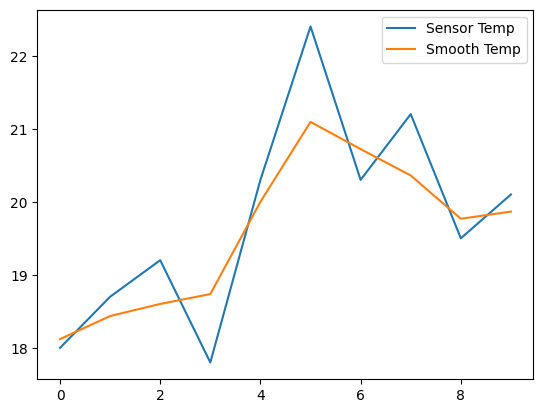

In [57]:
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()


We can also plot the observered measurements of the humidity against the **inferred real humidity** by our model. The **recovered humidity** is much less noisy than the real one.

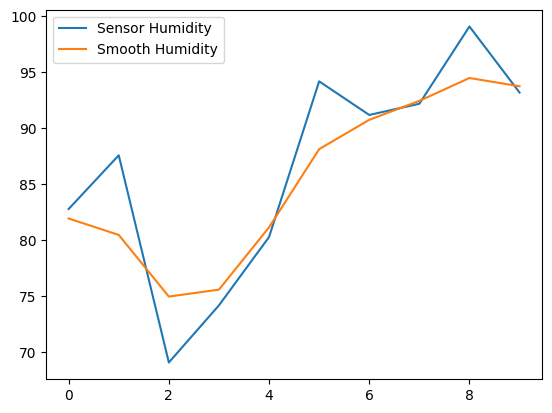

In [58]:
humidity = torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])
plt.plot(humidity.detach().numpy(), label='Sensor Humidity')
plt.plot(smooth_humidity, label='Smooth Humidity')
plt.legend()


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>
